In [ ]:
import csv
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics
import tensorflow as tf

from numpy import mean
from numpy import std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import activations
from tensorflow.keras import layers

In [ ]:
BATCH_SIZE = 64
MELTING_TEMPERATURE = 5
MIN_SNOW_CM = 0.5 # Above this value, we consider it as snow
NUM_EPOCHS = 12
OUTPUT_DATASET_FILE = "snow_dataset.csv"
TFL_MODEL_FILE = "snow_forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "snow_forecast_model.h"
TF_MODEL = "snow_forecast"

In [ ]:
!pip install wwo-hist
from wwo_hist import retrieve_hist_data

In [ ]:
frequency=1
api_key = '69c726f54598420ba1d50030230510'
location_list = ['98225']

# retrieve_hist_data returns a list of dataframe(s)
df_weather = retrieve_hist_data(api_key,
                                location_list,
                                '31-DEC-2012',
                                '31-DEC-2022',
                                frequency,
                                location_label = False,
                                export_csv = False,
                                store_df = True)



Retrieving weather data for 98225


Currently retrieving data for 98225: from 2012-12-31 to 2012-12-31
Time elapsed (hh:mm:ss.ms) 0:00:00.118042
Currently retrieving data for 98225: from 2013-01-01 to 2013-01-31


/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:69: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_begin = pd.date_range(start_date, end_date, freq='MS', closed='right')
/usr/local/lib/python3.10/dist-packages/wwo_hist/__init__.py:74: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  list_mon_end = pd.date_range(start_date, end_date, freq='M', closed='left')


Time elapsed (hh:mm:ss.ms) 0:00:05.600868
Currently retrieving data for 98225: from 2013-02-01 to 2013-02-28
Time elapsed (hh:mm:ss.ms) 0:00:06.573700
Currently retrieving data for 98225: from 2013-03-01 to 2013-03-31
Time elapsed (hh:mm:ss.ms) 0:00:07.641576
Currently retrieving data for 98225: from 2013-04-01 to 2013-04-30
Time elapsed (hh:mm:ss.ms) 0:00:08.667159
Currently retrieving data for 98225: from 2013-05-01 to 2013-05-31
Time elapsed (hh:mm:ss.ms) 0:00:10.503808
Currently retrieving data for 98225: from 2013-06-01 to 2013-06-30
Time elapsed (hh:mm:ss.ms) 0:00:17.781097
Currently retrieving data for 98225: from 2013-07-01 to 2013-07-31
Time elapsed (hh:mm:ss.ms) 0:00:23.732526
Currently retrieving data for 98225: from 2013-08-01 to 2013-08-31
Time elapsed (hh:mm:ss.ms) 0:00:25.048978
Currently retrieving data for 98225: from 2013-09-01 to 2013-09-30
Time elapsed (hh:mm:ss.ms) 0:00:25.580671
Currently retrieving data for 98225: from 2013-10-01 to 2013-10-31
Time elapsed (hh:mm

In [ ]:
df_weather

[             date_time maxtempC mintempC totalSnow_cm sunHour uvIndex  \
 0  2012-12-31 00:00:00        3       -2          0.0     8.2       2   
 1  2012-12-31 01:00:00        3       -2          0.0     8.2       2   
 2  2012-12-31 02:00:00        3       -2          0.0     8.2       2   
 3  2012-12-31 03:00:00        3       -2          0.0     8.2       2   
 4  2012-12-31 04:00:00        3       -2          0.0     8.2       2   
 ..                 ...      ...      ...          ...     ...     ...   
 19 2022-12-31 19:00:00        6        3          0.0     3.1       1   
 20 2022-12-31 20:00:00        6        3          0.0     3.1       1   
 21 2022-12-31 21:00:00        6        3          0.0     3.1       1   
 22 2022-12-31 22:00:00        6        3          0.0     3.1       1   
 23 2022-12-31 23:00:00        6        3          0.0     3.1       1   
 
    moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
 0                 78  08:20 PM  09:3

In [ ]:
# Extract temperature, humidity and precipitation
t_list = df_weather[0].tempC.astype(float).to_list()
h_list = df_weather[0].humidity.astype(float).to_list()
s_list = df_weather[0].totalSnow_cm.astype(float).to_list()

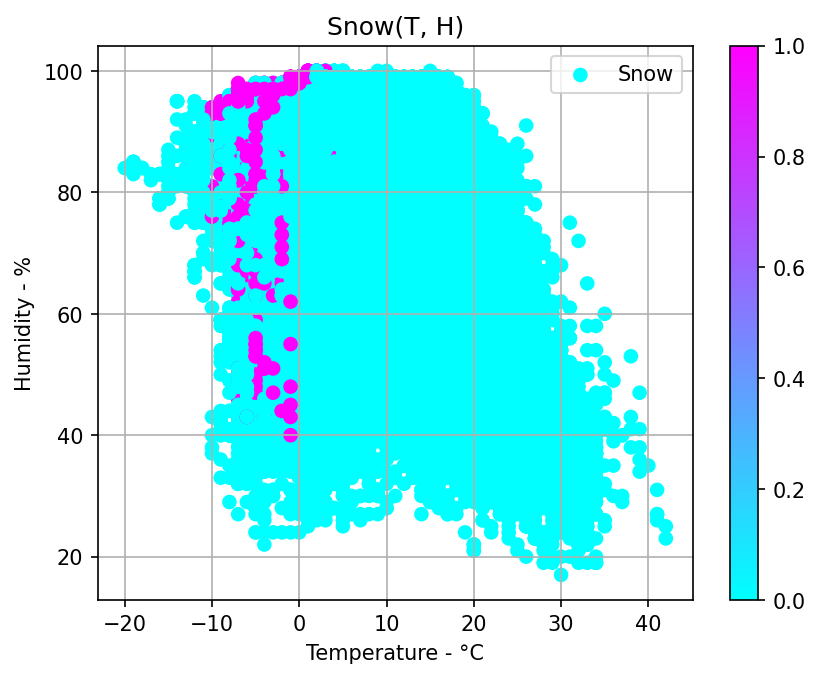

In [ ]:
def binarize(snow, threshold):
  if snow > threshold:
    return 1
  else:
    return 0

s_bin_list = [binarize(snow, 0.5) for snow in s_list]

cm = plt.colormaps['cool']
plt.figure(dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, label="Snow")
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

In [ ]:
def gen_label(snow, temperature):
  if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
    return "Yes"
  else:
    return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [ ]:
csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:], h_list[:-2], h_list[1:-1], h_list[2:], snow_labels[2:])), columns = csv_header)

In [ ]:
df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_old   = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
  df0_sub = df0.sample(len(df1.index))
  df_dataset = pd.concat([df0_sub, df1])
else:
  df1_sub = df1.sample(len(df0.index))
  df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

,Before - %,After - %
Class,,
% No Snow,97.57,50.0
% Snow,2.43,50.0


In [ ]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = mean(t_list)
h_avg = mean(h_list)
t_std = std(t_list)
h_std = std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

# Scaling with Z-score function
def scaling(val, avg, std):
  return (val - avg) / (std)

df_dataset['Temp0'] = df_dataset['Temp0'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp1'] = df_dataset['Temp1'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Temp2'] = df_dataset['Temp2'].apply(lambda x: scaling(x, t_avg, t_std))
df_dataset['Humi0'] = df_dataset['Humi0'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi1'] = df_dataset['Humi1'].apply(lambda x: scaling(x, h_avg, h_std))
df_dataset['Humi2'] = df_dataset['Humi2'].apply(lambda x: scaling(x, h_avg, h_std))

COPY ME!
Temperature - [MEAN, STD]   4.93618 7.57011
Humidity - [MEAN, STD]      84.68231 14.84663


<ipython-input-17-180eac70d47c>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(t_list, ax=ax[0])
<ipython-input-17-180eac70d47c>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(h_list, ax=ax[1])
<ipython-input-17-180eac70d47c>:15: UserWarning: 

`distplot` is a deprecated function and will b

Text(0.5, 1.0, 'Normalized humidity')

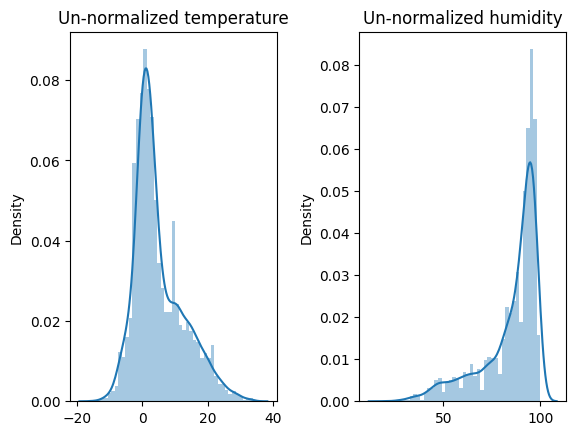

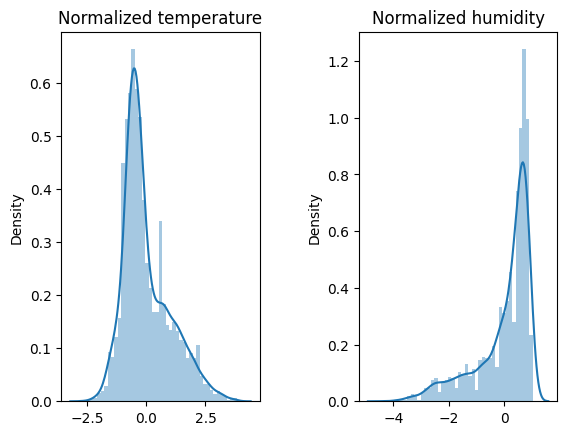

In [ ]:
t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.4)
sns.distplot(t_list, ax=ax[0])
ax[0].set_title("Un-normalized temperature")
sns.distplot(h_list, ax=ax[1])
ax[1].set_title("Un-normalized humidity")

fig, ax=plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
sns.distplot(t_norm_list, ax=ax[0])
ax[0].set_title("Normalized temperature")
sns.distplot(h_norm_list, ax=ax[1])
ax[1].set_title("Normalized humidity")

In [ ]:
df_dataset.to_csv(OUTPUT_DATASET_FILE, index=False)

In [ ]:
f_names = df_dataset.columns.values[0:6]
l_name  = df_dataset.columns.values[6:7]
x = df_dataset[f_names]
y = df_dataset[l_name]

In [ ]:
x

,Temp0,Temp1,Temp2,Humi0,Humi1,Humi2
66732,1.857809,1.989907,1.857809,-1.325709,-1.595131,-1.797197
10166,0.140529,0.008430,0.008430,0.425530,0.425530,0.492886
77336,0.404726,0.404726,0.536824,0.425530,0.358175,0.223464
59115,0.140529,0.140529,0.140529,-1.527775,-1.393065,-1.258354
76084,1.329415,1.197317,1.329415,0.964373,0.964373,0.964373
...,...,...,...,...,...,...
87473,-0.519963,-0.519963,-0.519963,1.031729,1.031729,1.031729
87474,-0.519963,-0.519963,-0.519963,1.031729,1.031729,1.031729
87475,-0.519963,-0.519963,-0.519963,1.031729,1.031729,1.031729
87476,-0.519963,-0.519963,-0.519963,1.031729,1.031729,0.964373


In [ ]:
y

,Snow
66732,No
10166,No
77336,No
59115,No
76084,No
...,...
87473,Yes
87474,Yes
87475,Yes
87476,Yes


In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(y.Snow)
y_encoded = labelencoder.transform(y.Snow)

In [ ]:
# Split 1 (85% vs 15%)
x_train, x_validate_test, y_train, y_validate_test = train_test_split(x, y_encoded, test_size=0.15, random_state = 1)
# Split 2 (50% vs 50%)
x_test, x_validate, y_test, y_validate = train_test_split(x_validate_test, y_validate_test, test_size=0.50, random_state = 3)

In [ ]:
x_train

,Temp0,Temp1,Temp2,Humi0,Humi1,Humi2
38703,2.122006,1.593612,1.461514,-2.268684,-1.393065,-0.517445
37091,0.404726,0.404726,0.404726,-0.180668,-0.382734,-0.450089
39085,1.593612,1.593612,1.593612,-1.258354,-1.460420,-1.662486
62971,-0.519963,-0.652062,-0.784160,0.829663,0.829663,0.762307
87139,-0.519963,-0.519963,-0.519963,0.694952,0.627597,0.627597
...,...,...,...,...,...,...
36638,-0.255766,-0.255766,-0.387865,0.762307,0.762307,0.762307
35940,-0.519963,-0.519963,-0.652062,0.560241,0.560241,0.560241
71747,0.140529,0.404726,0.536824,-0.652156,-0.988932,-1.190998
78966,-0.784160,-0.916259,-0.784160,0.694952,0.762307,0.829663


In [ ]:
x_test

,Temp0,Temp1,Temp2,Humi0,Humi1,Humi2
34889,-0.652062,-0.652062,-0.652062,0.897018,0.897018,0.829663
43544,-0.255766,-0.255766,-0.255766,0.290820,0.290820,0.425530
45143,-0.784160,-0.784160,-0.784160,0.560241,0.627597,0.694952
52618,0.008430,0.008430,0.140529,-1.797197,-1.999263,-2.133974
61645,-0.519963,-0.652062,-0.784160,0.762307,0.762307,0.762307
...,...,...,...,...,...,...
5239,1.725710,2.122006,2.518301,-1.527775,-1.999263,-2.538106
61613,-0.255766,-0.255766,-0.255766,0.762307,0.762307,0.829663
14412,2.650400,2.650400,2.650400,-3.279015,-3.211660,-3.076949
38758,0.668923,0.668923,0.536824,0.492886,0.425530,0.358175


In [ ]:
x_validate

,Temp0,Temp1,Temp2,Humi0,Humi1,Humi2
41930,-0.255766,-0.123668,-0.123668,0.829663,0.897018,0.829663
53583,-0.916259,-1.048357,-1.180456,-1.123643,-0.854222,-0.517445
2825,0.536824,0.404726,0.404726,0.829663,0.897018,0.897018
52518,-0.255766,-0.387865,-0.387865,-0.113313,-0.113313,-0.045957
78962,-0.784160,-0.916259,-0.916259,0.627597,0.560241,0.627597
...,...,...,...,...,...,...
8539,-0.784160,-0.784160,-0.784160,0.694952,0.694952,0.762307
36012,-0.784160,-0.652062,-0.784160,0.694952,0.694952,0.762307
75226,2.782498,2.914597,3.178794,-2.201329,-2.672817,-3.144304
61583,-0.784160,-0.916259,-0.784160,0.560241,0.560241,0.627597


In [ ]:
model = tf.keras.Sequential()
model.add(layers.Dense(12, activation='relu', input_shape=(len(f_names),)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97 (388.00 Byte)
Trainable params: 97 (388.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_validate, y_validate))

Epoch 1/12
57/57 [==============================] - 2s 11ms/step - loss: 0.5963 - accuracy: 0.6772 - val_loss: 0.5207 - val_accuracy: 0.7719
Epoch 2/12
57/57 [==============================] - 0s 4ms/step - loss: 0.4833 - accuracy: 0.8150 - val_loss: 0.4613 - val_accuracy: 0.8156
Epoch 3/12
57/57 [==============================] - 0s 7ms/step - loss: 0.4360 - accuracy: 0.8451 - val_loss: 0.4275 - val_accuracy: 0.8188
Epoch 4/12
57/57 [==============================] - 0s 9ms/step - loss: 0.4011 - accuracy: 0.8625 - val_loss: 0.4027 - val_accuracy: 0.8219
Epoch 5/12
57/57 [==============================] - 0s 8ms/step - loss: 0.3702 - accuracy: 0.8680 - val_loss: 0.3849 - val_accuracy: 0.8281
Epoch 6/12
57/57 [==============================] - 0s 8ms/step - loss: 0.3559 - accuracy: 0.8699 - val_loss: 0.3715 - val_accuracy: 0.8469
Epoch 7/12
57/57 [==============================] - 1s 10ms/step - loss: 0.3467 - accuracy: 0.8752 - val_loss: 0.3625 - val_accuracy: 0.8500
Epoch 8/12
57/57 [

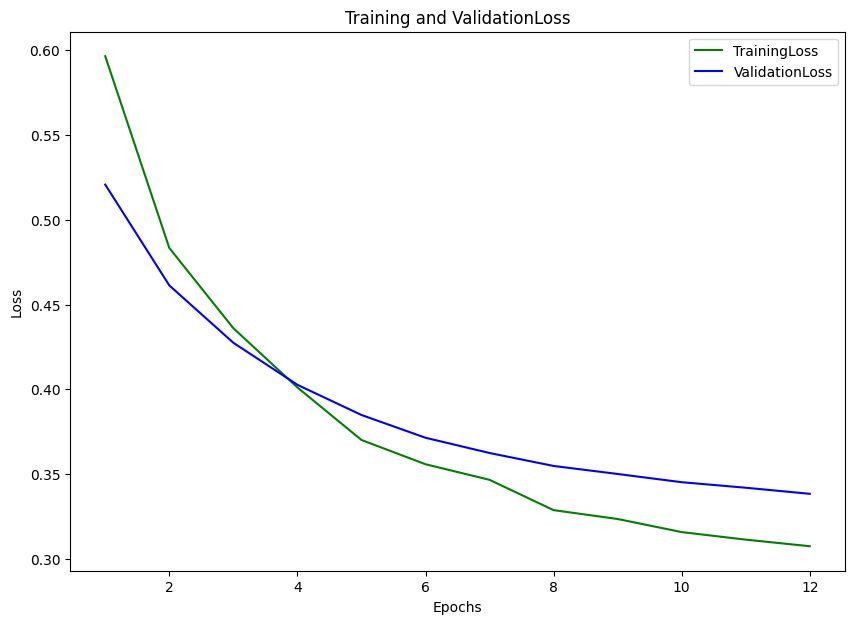

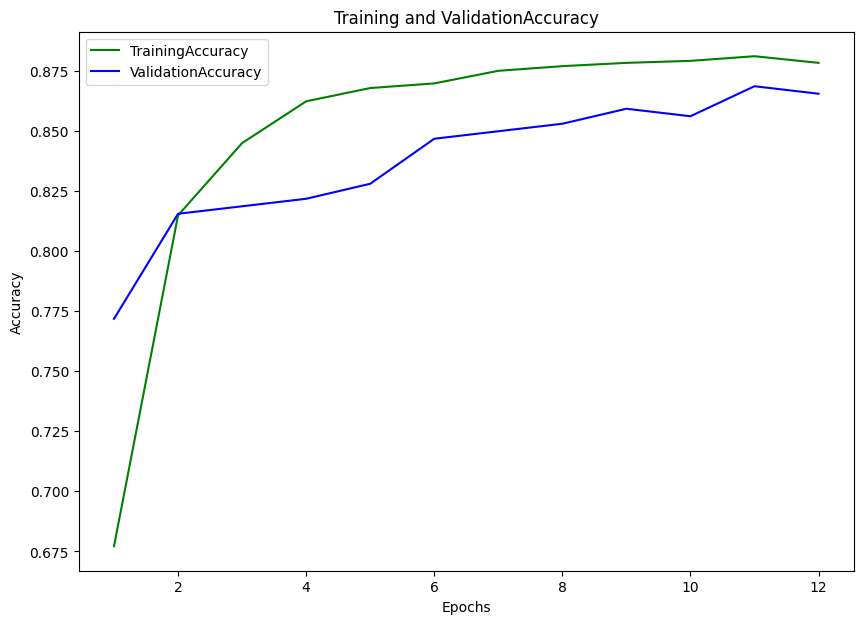

In [ ]:
loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, NUM_EPOCHS + 1)

def plot_train_val_history(x, y_train, y_val, type_txt):
  plt.figure(figsize = (10,7))
  plt.plot(x, y_train, 'g', label='Training'+type_txt)
  plt.plot(x, y_val, 'b', label='Validation'+type_txt)
  plt.title('Training and Validation'+type_txt)
  plt.xlabel('Epochs')
  plt.ylabel(type_txt)
  plt.legend()
  plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

In [ ]:
model.save(TF_MODEL)

10/10 [==============================] - 0s 2ms/step


<Figure size 1000x700 with 0 Axes>

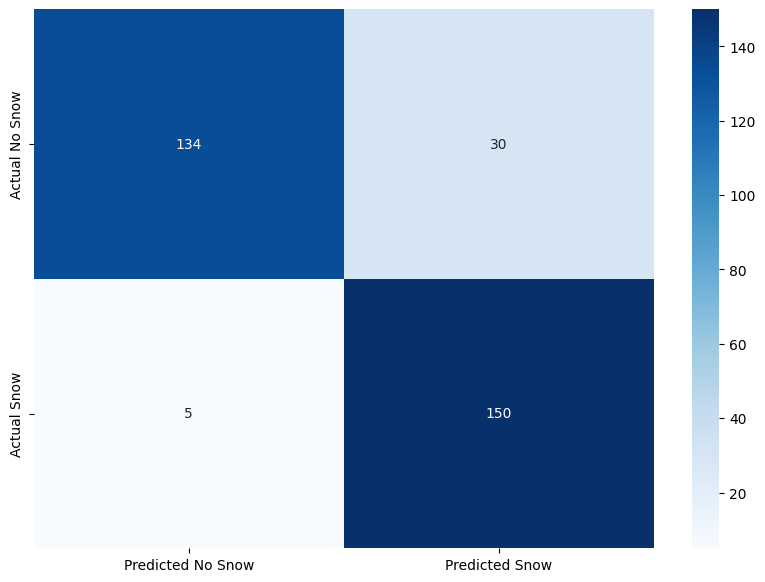

<Figure size 1000x700 with 0 Axes>

In [ ]:
y_test_pred = model.predict(x_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = sklearn.metrics.confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")
plt.figure(figsize = (10,7))

In [ ]:
TN = cm[0][0]
TP = cm[1][1]
FN = cm[1][0]
FP = cm[0][1]

accuracy = (TP + TN) / (TP + TN + FN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f_score = (2 * recall * precision) / (recall + precision)

print("Accuracy:  ", round(accuracy, 3))
print("Recall:    ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F-score:   ", round(f_score, 3))

Accuracy:   0.89
Recall:     0.968
Precision:  0.833
F-score:    0.896


In [ ]:
def representative_data_gen():
  for i_value in tf.data.Dataset.from_tensor_slices(x_test).batch(1).take(100):
    i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)

In [ ]:
# Representative dataset
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# Optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Supported ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Inference input/output type
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

In [ ]:
tflite_model_quant = converter.convert()
open(TFL_MODEL_FILE, "wb").write(tflite_model_quant)

2088

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i snow_forecast_model.tflite > model.h
!cat model.h

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,343 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,269 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-securit